# IS4226 Individual Assignment

## Group Members
1. Ryan Tan Jun Xiong - Student ID
2. Gabril yong ji
3. mattheew - 

In [1]:
# !pip3 install PyPortfolioOpt
!pip3 install cvxpy
!pip3 install scs
!pip3 install cvxopt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from pypfopt import risk_models, expected_returns, EfficientFrontier, DiscreteAllocation

# Step 1: Define the SGX stocks (this is an example selection, you can modify based on your analysis)
stocks = [
    # 'D05.SI',  # DBS Group Holdings (Banking)
    'O39.SI',  # Oversea-Chinese Banking Corp (Banking)
    'U11.SI',  # United Overseas Bank (Banking)
    'Z74.SI',  # Singtel (Telecommunications)
    "H78.SI",  # Hongkong Land Holdings Limited
    "9CI.SI",  # CapitaLand Investment Limited
    "A17U.SI", # CapitaLand Ascendas REIT
    'C38U.SI', # CapitaLand Ascendas REIT (Real Estate)
]

sector_mapper = {
    # 'D05.SI': 'Financial Services',
    'O39.SI': 'Financial Services',
    'U11.SI': 'Financial Services',
    'Z74.SI': 'Communication Services',
    'H78.SI': 'Real Estate',
    '9CI.SI': 'Real Estate',
    'A17U.SI': 'Real Estate',
    'C38U.SI': 'Real Estate'
}

def get_stock_info(tickers):
    """
    Get basic information about stocks
    """
    stock_info = []
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            
            stock_data = {
                'Symbol': ticker,
                'Name': info.get('longName', 'N/A'),
                'Sector': info.get('sector', 'N/A'),
                'Industry': info.get('industry', 'N/A'),
                'Market Cap': info.get('marketCap', 'N/A'),
                'Description': info.get('longBusinessSummary', 'N/A')
            }
            
            stock_info.append(stock_data)
            print(f"Successfully retrieved data for {ticker}")
            
        except Exception as e:
            print(f"Error retrieving data for {ticker}: {e}")
    
    return pd.DataFrame(stock_info)

# Get basic information about the stocks
stock_info_df = get_stock_info(stocks)
stock_info_df

Successfully retrieved data for O39.SI
Successfully retrieved data for U11.SI
Successfully retrieved data for Z74.SI
Successfully retrieved data for H78.SI
Successfully retrieved data for 9CI.SI
Successfully retrieved data for A17U.SI
Successfully retrieved data for C38U.SI


,Symbol,Name,Sector,Industry,Market Cap,Description
0,O39.SI,Oversea-Chinese Banking Corporation Limited,Financial Services,Banks - Regional,73962414080,"Oversea-Chinese Banking Corporation Limited, t..."
1,U11.SI,United Overseas Bank Limited,Financial Services,Banks - Regional,60815003648,"United Overseas Bank Limited, together with it..."
2,Z74.SI,Singapore Telecommunications Limited,Communication Services,Telecom Services,52182343680,"Singapore Telecommunications Limited, together..."
3,H78.SI,Hongkong Land Holdings Limited,Real Estate,Real Estate - Development,10304915456,"Hongkong Land Holdings Limited, together with ..."
4,9CI.SI,CapitaLand Investment Limited,Real Estate,Real Estate Services,13829003264,"Headquartered and listed in Singapore, CapitaL..."
5,A17U.SI,CapitaLand Ascendas REIT,Real Estate,REIT - Industrial,11300239360,CapitaLand Ascendas REIT (CLAR) is Singapore's...
6,C38U.SI,CapitaLand Integrated Commercial Trust,Real Estate,REIT - Retail,14427488256,CapitaLand Integrated Commercial Trust (CICT) ...


In [3]:
def download_stock_data(stocks, start_date, end_date):
    """Download stock data using yfinance"""
    df = pd.DataFrame()
    for stock in stocks:
        try:
            data = yf.download(stock, start=start_date, end=end_date)['Adj Close']
            if not data.empty:
                df[stock] = data
        except Exception as e:
            print(f"Error downloading {stock}: {e}")
    
    return df

train_start_date = '2015-01-01'
train_end_date = '2022-12-31'
test_start_date = '2023-01-01'
test_end_date = '2023-12-31'

# Get both training and testing data
stock_train_data = download_stock_data(stocks, train_start_date, train_end_date)
# Display the first few rows to inspect the data
print("\nFirst few rows of the price data:")
print(stock_train_data.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(stock_train_data.isnull().sum())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


First few rows of the price data:
              O39.SI     U11.SI    Z74.SI    H78.SI  9CI.SI   A17U.SI  \
Date                                                                    
2015-01-02  6.786471  16.155783  2.621396  4.506071     NaN  1.358686   
2015-01-05  6.689520  15.793246  2.614657  4.472939     NaN  1.364347   
2015-01-06  6.566718  15.371393  2.587701  4.545831     NaN  1.341703   
2015-01-07  6.579644  15.450489  2.601179  4.764508     NaN  1.358686   
2015-01-08  6.786471  15.832798  2.655089  4.810894     NaN  1.358686   

             C38U.SI  
Date                  
2015-01-02  1.223344  
2015-01-05  1.229341  
2015-01-06  1.211351  
2015-01-07  1.247331  
2015-01-08  1.217348  

Missing values in the dataset:
O39.SI        0
U11.SI        0
Z74.SI        0
H78.SI        0
9CI.SI     1686
A17U.SI       0
C38U.SI       0
dtype: int64


In [4]:
stock_test_data = download_stock_data(stocks, test_start_date, test_end_date)
print("\last few rows of the price data:")
print(stock_test_data.tail())
print("\nMissing values in the dataset:")
print(stock_test_data.isnull().sum())

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/2762543545.py:2: SyntaxWarning: invalid escape sequence '\l'
  print("\last few rows of the price data:")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

\last few rows of the price data:
               O39.SI     U11.SI  Z74.SI    H78.SI    9CI.SI   A17U.SI  \
Date                                                                     
2023-12-22  11.907200  26.059362    2.44  3.157852  2.845564  2.810781   
2023-12-26  11.897795  26.106571    2.43  3.139166  2.864662  2.801317   
2023-12-27  12.020064  26.342615    2.42  3.185880  2.912406  2.810781   
2023-12-28  12.151739  26.795820    2.46  3.251280  2.960150  2.829709   
2023-12-29  12.226982  26.861916    2.47  3.251280  3.017444  2.867564   

             C38U.SI  
Date                  
2023-12-22  1.876445  
2023-12-26  1.876445  
2023-12-27  1.895209  
2023-12-28  1.913974  
2023-12-29  1.932738  

Missing values in the dataset:
O39.SI     0
U11.SI     0
Z74.SI     0
H78.SI     0
9CI.SI     0
A17U.SI    0
C38U.SI    0
dtype: int64


In [5]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(stock_train_data, frequency=252)
mu

O39.SI     0.059447
U11.SI     0.068677
Z74.SI    -0.006427
H78.SI    -0.012515
9CI.SI     0.200247
A17U.SI    0.076911
C38U.SI    0.050789
dtype: float64

In [6]:
S = CovarianceShrinkage(stock_train_data, frequency=252).ledoit_wolf()
S

,O39.SI,U11.SI,Z74.SI,H78.SI,9CI.SI,A17U.SI,C38U.SI
O39.SI,0.030202,0.025340,0.015860,0.013275,0.001853,0.013629,0.014786
U11.SI,0.025340,0.032661,0.015902,0.012679,0.001934,0.013060,0.013840
Z74.SI,0.015860,0.015902,0.033092,0.010762,0.001859,0.013872,0.014190
H78.SI,0.013275,0.012679,0.010762,0.056112,0.004158,0.011521,0.014834
9CI.SI,0.001853,0.001934,0.001859,0.004158,0.011441,0.002928,0.003805
A17U.SI,0.013629,0.013060,0.013872,0.011521,0.002928,0.038599,0.025824
C38U.SI,0.014786,0.013840,0.014190,0.014834,0.003805,0.025824,0.045785


# 5. Optiimize portfolio with Efficient Frontier

In [7]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('O39.SI', 0.0),
             ('U11.SI', 0.03191),
             ('Z74.SI', 0.0),
             ('H78.SI', 0.0),
             ('9CI.SI', 0.96118),
             ('A17U.SI', 0.00691),
             ('C38U.SI', 0.0)])

In [8]:
ef.portfolio_performance(verbose=True)

Expected annual return: 19.5%
Annual volatility: 10.4%
Sharpe Ratio: 1.69


(0.19519643437510925, 0.10376848510829512, 1.6883395203492693)


Individual Stock Performance:

O39.SI (Weight: 0.0%):
Total Return: 11.05%
Annual Volatility: 14.84%
Sharpe Ratio: 0.63

U11.SI (Weight: 3.2%):
Total Return: 25.46%
Annual Volatility: 17.27%
Sharpe Ratio: 1.11

Z74.SI (Weight: 0.0%):
Total Return: 10.30%
Annual Volatility: 17.41%
Sharpe Ratio: 0.53

H78.SI (Weight: 0.0%):
Total Return: 11.20%
Annual Volatility: 27.35%
Sharpe Ratio: 0.44

9CI.SI (Weight: 96.1%):
Total Return: 26.36%
Annual Volatility: 26.26%
Sharpe Ratio: 0.82

A17U.SI (Weight: 0.7%):
Total Return: -6.13%
Annual Volatility: 16.12%
Sharpe Ratio: -0.23

C38U.SI (Weight: 0.0%):
Total Return: 7.20%
Annual Volatility: 20.33%
Sharpe Ratio: 0.37

Portfolio Performance:
Total Return: 26.28%
Annual Volatility: 25.44%
Sharpe Ratio: 0.84


/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/1547149019.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = cumulative_returns[column][-1] - 1
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/1547149019.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = portfolio_cumulative_returns[-1] - 1


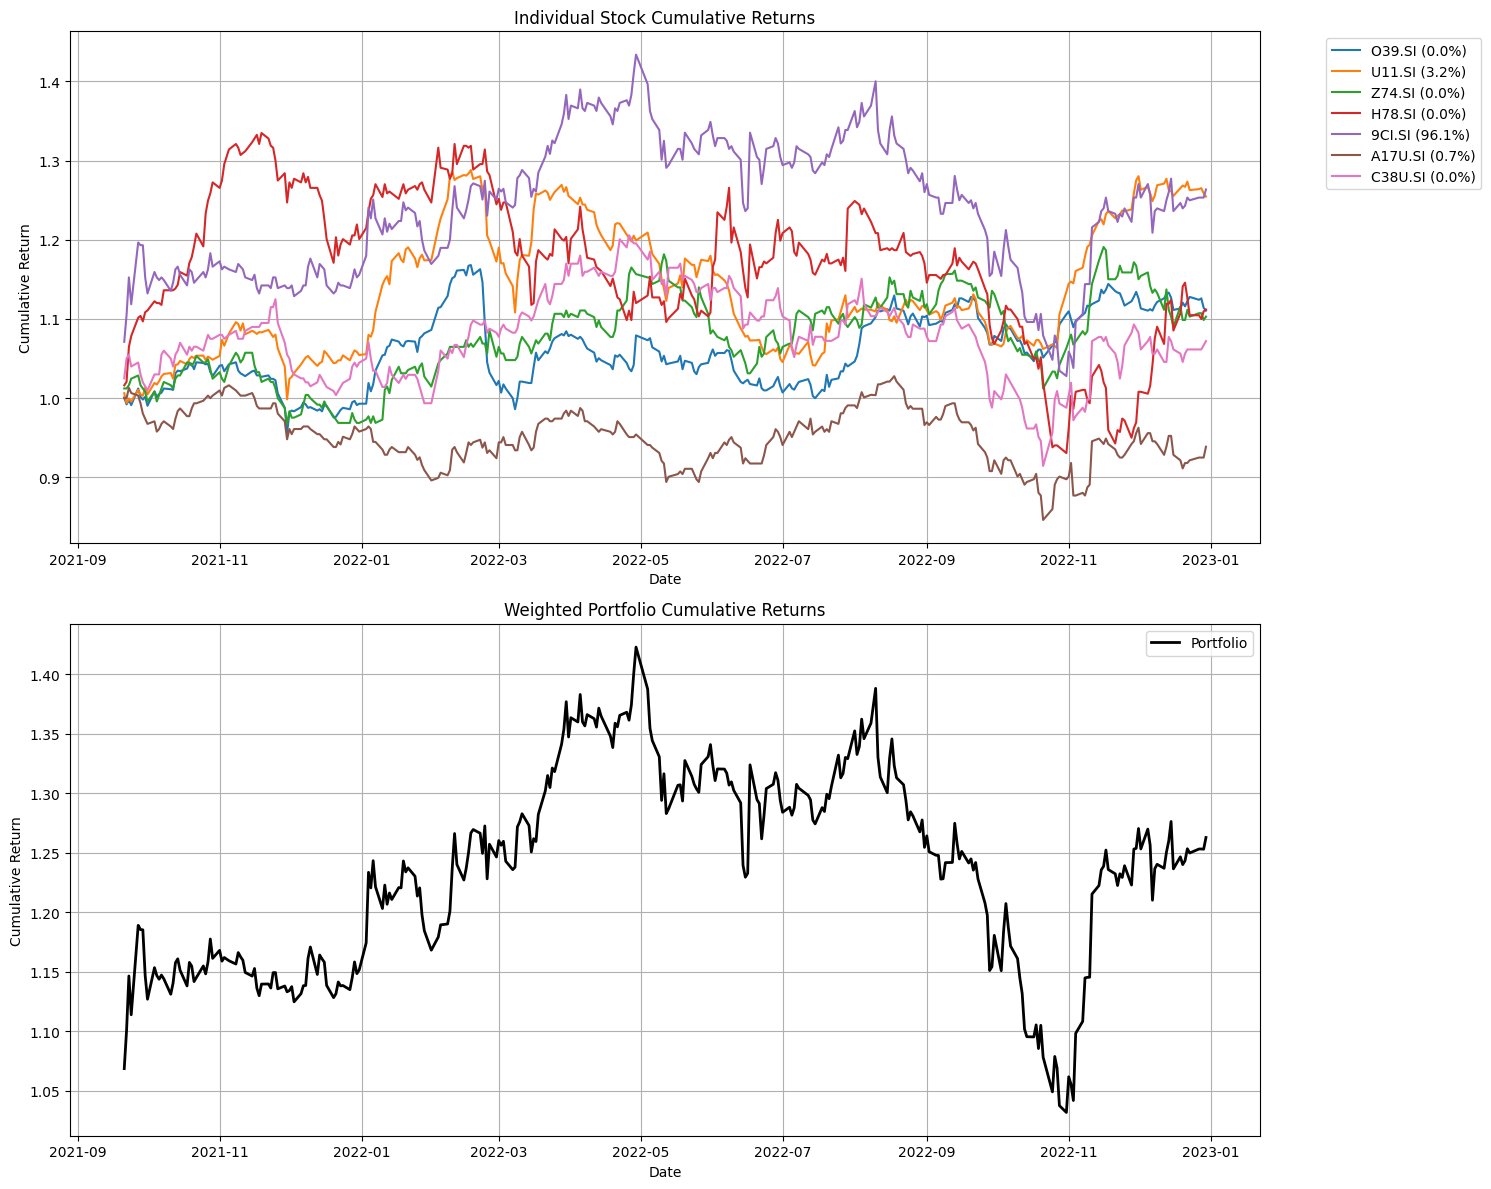

In [9]:
def plot_all_cumulative_returns(data, weights):
    # Ensure index is datetime
    data.index = pd.to_datetime(data.index)
    # Calculate daily returns for each stock
    daily_returns = data.pct_change().dropna()
    
    # Calculate cumulative returns for each stock
    cumulative_returns = (1 + daily_returns).cumprod()
    
    # Calculate weighted portfolio returns
    portfolio_daily_returns = daily_returns.dot(pd.Series(weights))
    portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot individual stock cumulative returns
    for column in cumulative_returns.columns:
        ax1.plot(cumulative_returns.index, cumulative_returns[column], label=f"{column} ({weights[column]*100:.1f}%)")
    
    ax1.set_title('Individual Stock Cumulative Returns')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Return')
    ax1.grid(True)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot weighted portfolio cumulative returns
    ax2.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, 
            label='Portfolio', color='black', linewidth=2)
    ax2.set_title('Weighted Portfolio Cumulative Returns')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    
    # Print performance metrics
    print("\nIndividual Stock Performance:")
    for column in cumulative_returns.columns:
        total_return = cumulative_returns[column][-1] - 1
        annual_vol = daily_returns[column].std() * np.sqrt(252)
        sharpe = (daily_returns[column].mean() * 252) / (daily_returns[column].std() * np.sqrt(252))
        print(f"\n{column} (Weight: {weights[column]*100:.1f}%):")
        print(f"Total Return: {total_return*100:.2f}%")
        print(f"Annual Volatility: {annual_vol*100:.2f}%")
        print(f"Sharpe Ratio: {sharpe:.2f}")
    
    print("\nPortfolio Performance:")
    total_return = portfolio_cumulative_returns[-1] - 1
    annual_vol = portfolio_daily_returns.std() * np.sqrt(252)
    sharpe = (portfolio_daily_returns.mean() * 252) / (portfolio_daily_returns.std() * np.sqrt(252))
    print(f"Total Return: {total_return*100:.2f}%")
    print(f"Annual Volatility: {annual_vol*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    
    return {
        'individual_returns': cumulative_returns,
        'portfolio_returns': portfolio_cumulative_returns,
        'daily_returns': daily_returns,
        'portfolio_daily_returns': portfolio_daily_returns
    }

# Use the function
results = plot_all_cumulative_returns(
    data=stock_train_data,
    weights=pd.Series(cleaned_weights)
)

# # Optional: Print first few and last few values of both individual and portfolio returns
# print("\nFirst few days of cumulative returns:")
# print(results['individual_returns'].head())
# print("\nLast few days of cumulative returns:")
# print(results['individual_returns'].tail())

# 6 Backtest

## 6a Calculate Returns to determine performance

In [10]:
def calculate_returns_manual(data, weights):
    stock_returns = data.pct_change().dropna()
    portfolio_returns = stock_returns.dot(pd.Series(weights))
    cumulative_returns = (1 + portfolio_returns).cumprod()
    return {
        'total_returns': cumulative_returns[-1] - 1,
        'annual_volatility': portfolio_returns.std() * np.sqrt(252),
        'sharpe_ratio': (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252))
    }

train_cumulative_returns = calculate_returns_manual(stock_train_data, pd.Series(cleaned_weights))
train_cumulative_returns

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/1722692436.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'total_returns': cumulative_returns[-1] - 1,


{'total_returns': 0.2628297470483576,
 'annual_volatility': 0.25441542334480144,
 'sharpe_ratio': 0.8414464095089768}

In [11]:
train_cumulative_returns = calculate_returns_manual(stock_test_data, pd.Series(cleaned_weights))
train_cumulative_returns

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/1722692436.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'total_returns': cumulative_returns[-1] - 1,


{'total_returns': -0.10602709122252107,
 'annual_volatility': 0.2148581220149846,
 'sharpe_ratio': -0.4230671402673835}

## 6b Portfolio
Follow the section on “Post Processing Weights” in order to get the number of shares to purchase from the weights. If that does not work, you can manually come up with a logic to determine how many shares of the stock you should buy from the weights (highly encourage you use DiscreteAllocation library if possible to reduce possibility of miscalculations). You can assume you are managing a $1,000,000 portfolio for convenience.
Compute the Portfolio Value by multiplying the number of shares with the stock prices everyday. Compute the daily portfolio return series by tracking the changes in this total Portfolio value. We compute the total portfolio return and standard deviation from this return series. (and also the sharpe ratio)

In [12]:
import cvxpy
cvxpy.installed_solvers()

['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']

In [13]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(stock_train_data)
da = DiscreteAllocation(weights=cleaned_weights, latest_prices=latest_prices, total_portfolio_value=1000000)
allocation, leftover = da.lp_portfolio(solver='GLPK_MI') # GPLPK_MI is the only possible working solver

In [14]:
print("\nMethod 2 - Discrete Allocation:")
print("Number of shares per stock:")
for asset, shares in allocation.items():
    print(f"{asset}: {shares}")
print(f"Funds remaining: ${leftover:.2f}")


Method 2 - Discrete Allocation:
Number of shares per stock:
U11.SI: 1163
9CI.SI: 285408
A17U.SI: 2818
Funds remaining: $1.33


In [15]:
def calculate_discrete_portfolio_performance(stock_data, allocation, leftover):
    # Calculate daily portfolio value
    portfolio_values = pd.DataFrame(index=stock_data.index)
    portfolio_values['Portfolio Value'] = 0

    for date in stock_data.index:
        portfolio_values.loc[date, 'Portfolio Value'] = sum(
            allocation[asset] * stock_data.loc[date, asset] 
            for asset in allocation.keys()
        ) + leftover

    # Calculate returns from portfolio values
    portfolio_returns = portfolio_values['Portfolio Value'].pct_change().dropna()
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    # Calculate performance metrics
    total_return = cumulative_returns[-1] - 1
    annual_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252))
    
    return {
        'total_return': total_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        # 'cumulative_returns' : cumulative_returns
    }

calculate_discrete_portfolio_performance(stock_train_data, allocation=allocation, leftover=leftover)

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3030672245.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = cumulative_returns[-1] - 1


{'total_return': 0.2602836748560007,
 'annual_volatility': 0.2547370610077049,
 'sharpe_ratio': 0.8345220241528719}

In [16]:
calculate_discrete_portfolio_performance(stock_test_data, allocation=allocation, leftover=leftover)

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3030672245.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1007793.3714237213' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_values.loc[date, 'Portfolio Value'] = sum(
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3030672245.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = cumulative_returns[-1] - 1


{'total_return': -0.10643876516117445,
 'annual_volatility': 0.2146553715689814,
 'sharpe_ratio': -0.4258429438799128}

## 6c Comparison
What is the difference in the above two approaches? Why do they lead to different results?

Answer: 6a and 6b are different because 6a calculates returns based on the assumption that fractional shares can be purchased, however, 6b allocates the portfolio based on the current price, and assumes that fractional shares are not possible, so it finds the next best amount of shares where the correct proportion of shares can be purchased, together with a leftover pile. As such, the total returns on the portfolio would be lower using the DiscreteAllocation method compared to using returns.

# 7 Sector Comparison

In [17]:
sector_lower = {
    'Communication Services': 0.2,
}

sector_upper = {
    'Financial Services': 0.4,
    'Real Estate': 0.2
}

weight_bounds = [
    {
        'sector_lower' : {
            'Communication Services': 0.2,
        },
        'sector_upper' : {
            'Financial Services': 0.4,
            'Real Estate': 0.2,
        }
    },
    {
        'sector_lower' : {
            'Communication Services': 0.1,
        },
        'sector_upper' : {
            'Financial Services': 0.3,
            'Real Estate': 0.1,
        }
    }
]

def optimize_portfolio_sector_constraints(mu, S, sector_mapper, sector_lower, sector_upper):
    ef = EfficientFrontier(mu, S, solver="OSQP")
    ef.add_sector_constraints(sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    ef.portfolio_performance(verbose=True)
    return cleaned_weights


weights_2 = optimize_portfolio_sector_constraints(mu, S, sector_mapper, sector_lower=weight_bounds[0]['sector_lower'], sector_upper=weight_bounds[0]['sector_upper'])
print(weights_2)
weights_3 = optimize_portfolio_sector_constraints(mu, S, sector_mapper, sector_lower=weight_bounds[1]['sector_lower'], sector_upper=weight_bounds[1]['sector_upper'])
print(weights_3)

Expected annual return: 6.5%
Annual volatility: 12.9%
Sharpe Ratio: 0.35
OrderedDict({'O39.SI': 0.0, 'U11.SI': 0.4, 'Z74.SI': 0.4, 'H78.SI': 0.0, '9CI.SI': 0.2, 'A17U.SI': 0.0, 'C38U.SI': 0.0})
Expected annual return: 3.7%
Annual volatility: 14.5%
Sharpe Ratio: 0.12
OrderedDict({'O39.SI': 0.0, 'U11.SI': 0.3, 'Z74.SI': 0.6, 'H78.SI': 0.0, '9CI.SI': 0.1, 'A17U.SI': 0.0, 'C38U.SI': 0.0})


# 8 Performance Discussion

## Portfolio 1 : No Sector Constraints

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  benchmark_latest_price = benchmark_train_price[-1]
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1007793.3714237213' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_values.loc[date, 'Portfolio Value'] = sum(
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:117: FutureWarning: Series.__getitem__ treat


Performance Comparison:
Metric                  Portfolio    Benchmark
--------------------------------------------
total_return             -10.64%      -0.97%
annual_volatility         21.47%       9.94%
sharpe_ratio               -0.43       -0.05
max_drawdown             -23.75%     -10.02%
skewness                    0.20        0.21
kurtosis                    1.35        0.51

Portfolio Allocation:
U11.SI: 1,163 shares ($31,906.39, 3.19%)
9CI.SI: 285,408 shares ($961,180.25, 96.12%)
A17U.SI: 2,818 shares ($6,912.03, 0.69%)
Cash: $1.33
Total Portfolio Value: $1,000,000.00

Benchmark Allocation:
STI Index: 307 shares ($997,516.68)
Cash: $2483.32
Total Benchmark Value: $1,000,000.00


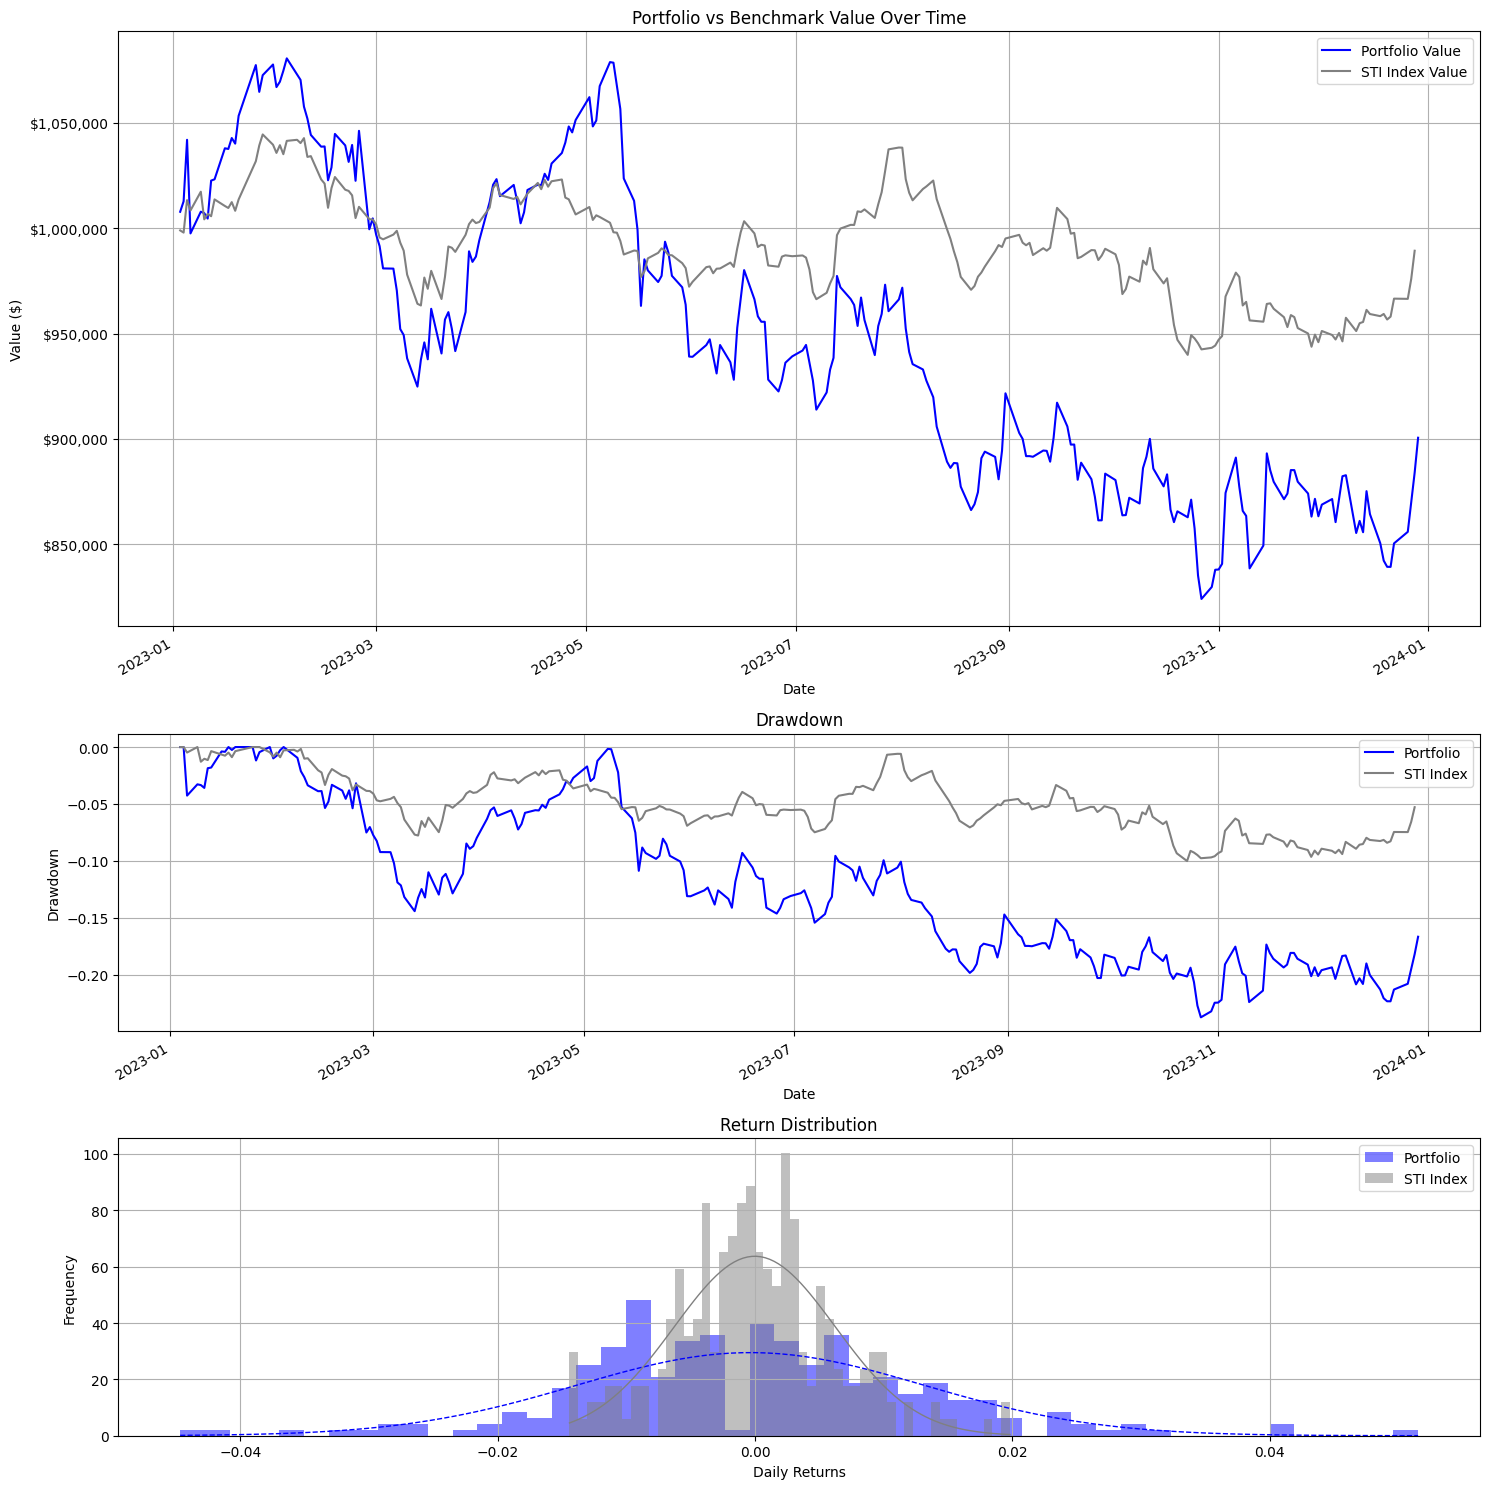

In [29]:
def analyze_portfolio_performance(stock_train_data, stock_test_data, weights, initial_investment=1000000):
    """
    Analyze portfolio performance using discrete allocation and compare with benchmark
    """
    # Get benchmark data (STI index)
    benchmark_data = yf.download('^STI', 
                               start=stock_test_data.index[0],
                               end=stock_test_data.index[-1])['Adj Close']
    
    # 1. Discrete Allocation for portfolio
    latest_prices = get_latest_prices(stock_train_data)
    da = DiscreteAllocation(weights=weights, 
                           latest_prices=latest_prices, 
                           total_portfolio_value=initial_investment)
    allocation, leftover = da.lp_portfolio(solver='GLPK_MI')
    
    # Calculate discrete allocation for benchmark
    benchmark_train_price = yf.download('^STI', 
                                      start=stock_train_data.index[0],
                                      end=stock_train_data.index[-1])['Adj Close']
    benchmark_latest_price = benchmark_train_price[-1]
    benchmark_shares = initial_investment // benchmark_latest_price
    benchmark_leftover = initial_investment - (benchmark_shares * benchmark_latest_price)
    
    # 2. Calculate portfolio values and returns
    def calculate_portfolio_values(stock_data, allocation, leftover):
        portfolio_values = pd.DataFrame(index=stock_data.index)
        portfolio_values['Portfolio Value'] = 0
        
        for date in stock_data.index:
            portfolio_values.loc[date, 'Portfolio Value'] = sum(
                allocation[asset] * stock_data.loc[date, asset] 
                for asset in allocation.keys()
            ) + leftover
        return portfolio_values
    
    # Calculate benchmark values
    def calculate_benchmark_values(benchmark_prices, shares, leftover):
        benchmark_values = pd.DataFrame(index=benchmark_prices.index)
        benchmark_values['Value'] = benchmark_prices * shares + leftover
        return benchmark_values
    
    # Calculate daily returns and drawdown
    def calculate_metrics(values):
        returns = values.pct_change().dropna()
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        return returns, cumulative_returns, drawdown
    
    # Calculate portfolio metrics
    portfolio_values = calculate_portfolio_values(stock_test_data, allocation, leftover)
    portfolio_returns, portfolio_cum_returns, portfolio_drawdown = calculate_metrics(portfolio_values['Portfolio Value'])
    
    # Calculate benchmark metrics with discrete allocation
    benchmark_values = calculate_benchmark_values(benchmark_data, benchmark_shares, benchmark_leftover)
    benchmark_returns, benchmark_cum_returns, benchmark_drawdown = calculate_metrics(benchmark_values['Value'])
    
    # 3. Create visualization
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])
    
    # Plot portfolio and benchmark values
    ax1 = fig.add_subplot(gs[0])
    portfolio_values['Portfolio Value'].plot(ax=ax1, label='Portfolio Value', color='blue')
    benchmark_values['Value'].plot(ax=ax1, label='STI Index Value', color='grey')
    ax1.set_title('Portfolio vs Benchmark Value Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value ($)')
    ax1.grid(True)
    ax1.legend()
    
    # Format y-axis with dollar signs and commas
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Plot drawdown
    ax2 = fig.add_subplot(gs[1])
    portfolio_drawdown.plot(ax=ax2, label='Portfolio', color='blue')
    benchmark_drawdown.plot(ax=ax2, label='STI Index', color='grey')
    ax2.set_title('Drawdown')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown')
    ax2.grid(True)
    ax2.legend()
    
    # Plot return distribution
    ax3 = fig.add_subplot(gs[2])
    
    # Create return distribution plots
    portfolio_returns.hist(ax=ax3, bins=50, alpha=0.5, label='Portfolio', color='blue', density=True)
    benchmark_returns.hist(ax=ax3, bins=50, alpha=0.5, label='STI Index', color='grey', density=True)
    
    # Add normal distribution curve
    from scipy import stats
    x_port = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 100)
    x_bench = np.linspace(benchmark_returns.min(), benchmark_returns.max(), 100)
    
    port_mean, port_std = portfolio_returns.mean(), portfolio_returns.std()
    bench_mean, bench_std = benchmark_returns.mean(), benchmark_returns.std()
    
    port_dist = stats.norm.pdf(x_port, port_mean, port_std)
    bench_dist = stats.norm.pdf(x_bench, bench_mean, bench_std)
    
    ax3.plot(x_port, port_dist, 'b--', linewidth=1)
    ax3.plot(x_bench, bench_dist, 'grey', linewidth=1)
    
    ax3.set_title('Return Distribution')
    ax3.set_xlabel('Daily Returns')
    ax3.set_ylabel('Frequency')
    ax3.grid(True)
    ax3.legend()
    
    plt.tight_layout()
    
    # 4. Calculate performance metrics
    def calculate_performance_metrics(returns, cum_returns, drawdown):
        total_return = cum_returns[-1] - 1
        annual_volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
        max_drawdown = drawdown.min()
        skewness = returns.skew()
        kurtosis = returns.kurtosis()
        
        return {
            'total_return': total_return,
            'annual_volatility': annual_volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'skewness': skewness,
            'kurtosis': kurtosis
        }
    
    portfolio_metrics = calculate_performance_metrics(portfolio_returns, portfolio_cum_returns, portfolio_drawdown)
    benchmark_metrics = calculate_performance_metrics(benchmark_returns, benchmark_cum_returns, benchmark_drawdown)
    
    # Print performance comparison
    print("\nPerformance Comparison:")
    metrics = ['total_return', 'annual_volatility', 'sharpe_ratio', 'max_drawdown', 'skewness', 'kurtosis']
    print(f"{'Metric':<20} {'Portfolio':>12} {'Benchmark':>12}")
    print("-" * 44)
    for metric in metrics:
        portfolio_value = portfolio_metrics[metric]
        benchmark_value = benchmark_metrics[metric]
        if metric in ['total_return', 'annual_volatility', 'max_drawdown']:
            print(f"{metric:<20} {portfolio_value:>11.2%} {benchmark_value:>11.2%}")
        else:
            print(f"{metric:<20} {portfolio_value:>11.2f} {benchmark_value:>11.2f}")
    
    # Print portfolio allocation
    print("\nPortfolio Allocation:")
    total_value = 0
    for asset, shares in allocation.items():
        value = shares * latest_prices[asset]
        total_value += value
        weight = value / initial_investment
        print(f"{asset}: {shares:,} shares (${value:,.2f}, {weight:.2%})")
    print(f"Cash: ${leftover:.2f}")
    print(f"Total Portfolio Value: ${total_value + leftover:,.2f}")
    
    # Print benchmark allocation
    print("\nBenchmark Allocation:")
    print(f"STI Index: {benchmark_shares:,.0f} shares (${benchmark_shares * benchmark_latest_price:,.2f})")
    print(f"Cash: ${benchmark_leftover:.2f}")
    print(f"Total Benchmark Value: ${benchmark_shares * benchmark_latest_price + benchmark_leftover:,.2f}")
    
    return {
        'allocation': allocation,
        'leftover': leftover,
        'benchmark_shares': benchmark_shares,
        'benchmark_leftover': benchmark_leftover,
        'portfolio_metrics': portfolio_metrics,
        'benchmark_metrics': benchmark_metrics,
        'portfolio_values': portfolio_values,
        'benchmark_values': benchmark_values,
        'portfolio_returns': portfolio_returns,
        'portfolio_drawdown': portfolio_drawdown,
        'benchmark_returns': benchmark_returns,
        'benchmark_drawdown': benchmark_drawdown
    }

# Usage example:
results = analyze_portfolio_performance(
    stock_train_data=stock_train_data,
    stock_test_data=stock_test_data,
    weights=cleaned_weights
)

# latest_prices = get_latest_prices(stock_train_data)
# da = DiscreteAllocation(weights=cleaned_weights, latest_prices=latest_prices, total_portfolio_value=1000000)
# allocation, leftover = da.lp_portfolio(solver='GLPK_MI') # GPLPK_MI is the only possible working solver

## Portfolio 2 : Sector Constraint 1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  benchmark_latest_price = benchmark_train_price[-1]
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '998508.7249732018' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_values.loc[date, 'Portfolio Value'] = sum(
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:117: FutureWarning: Series.__getitem__ treati


Performance Comparison:
Metric                  Portfolio    Benchmark
--------------------------------------------
total_return              -3.09%      -0.97%
annual_volatility         12.90%       9.94%
sharpe_ratio               -0.18       -0.05
max_drawdown             -10.43%     -10.02%
skewness                   -0.35        0.21
kurtosis                    1.22        0.51

Portfolio Allocation:
U11.SI: 14,580 shares ($399,995.87, 40.00%)
Z74.SI: 160,640 shares ($400,000.57, 40.00%)
9CI.SI: 59,387 shares ($200,000.04, 20.00%)
Cash: $3.52
Total Portfolio Value: $1,000,000.00

Benchmark Allocation:
STI Index: 307 shares ($997,516.68)
Cash: $2483.32
Total Benchmark Value: $1,000,000.00


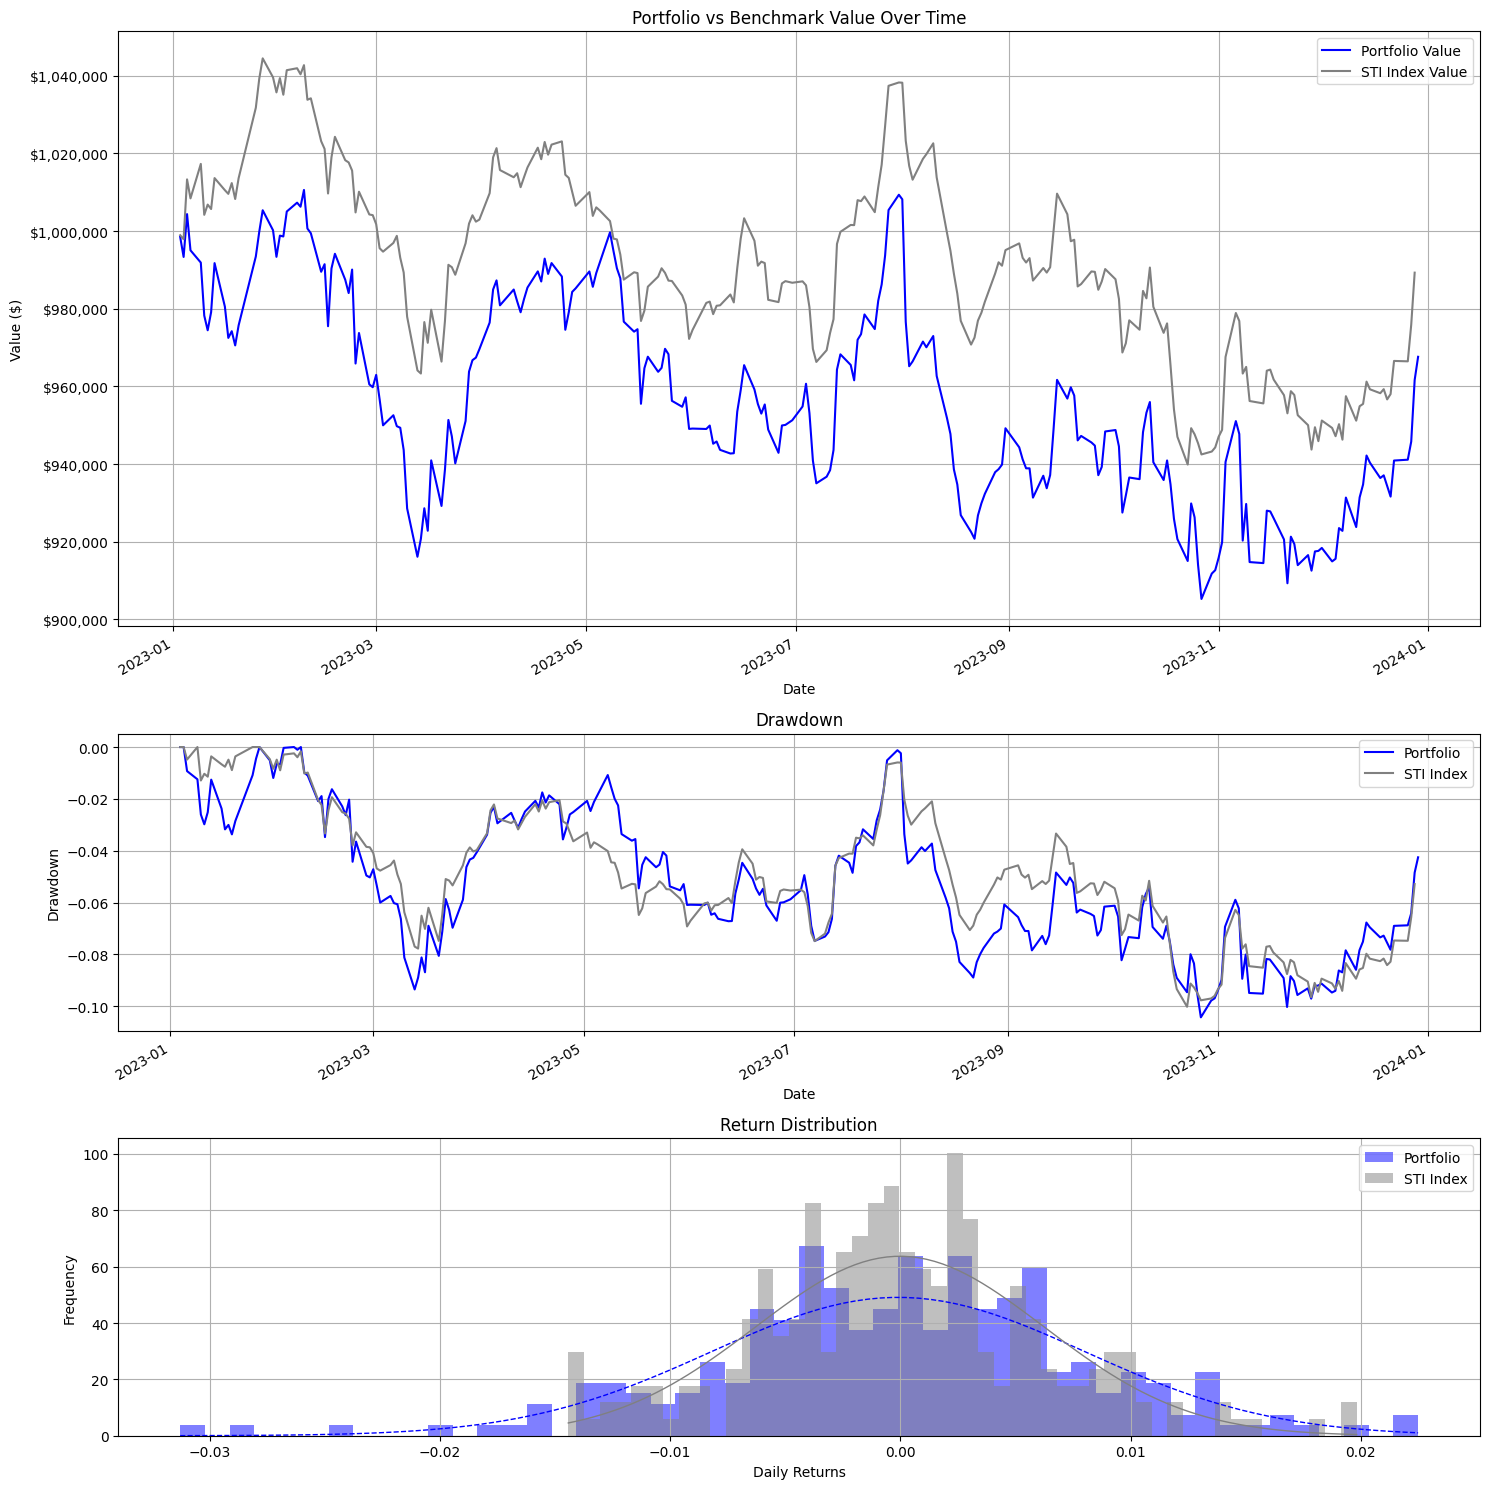

In [30]:
results_2 = analyze_portfolio_performance(
    stock_train_data=stock_train_data,
    stock_test_data=stock_test_data,
    weights=weights_2
)

## Portfolio 3 : Sector Constraint 2

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  benchmark_latest_price = benchmark_train_price[-1]
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '996141.4958047867' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_values.loc[date, 'Portfolio Value'] = sum(
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3774/3863518489.py:117: FutureWarning: Series.__getitem__ treati


Performance Comparison:
Metric                  Portfolio    Benchmark
--------------------------------------------
total_return              -1.77%      -0.97%
annual_volatility         13.53%       9.94%
sharpe_ratio               -0.07       -0.05
max_drawdown             -10.77%     -10.02%
skewness                   -0.77        0.21
kurtosis                    2.52        0.51

Portfolio Allocation:
U11.SI: 10,935 shares ($299,996.90, 30.00%)
Z74.SI: 240,960 shares ($600,000.86, 60.00%)
9CI.SI: 29,694 shares ($100,001.70, 10.00%)
Cash: $0.54
Total Portfolio Value: $1,000,000.00

Benchmark Allocation:
STI Index: 307 shares ($997,516.68)
Cash: $2483.32
Total Benchmark Value: $1,000,000.00


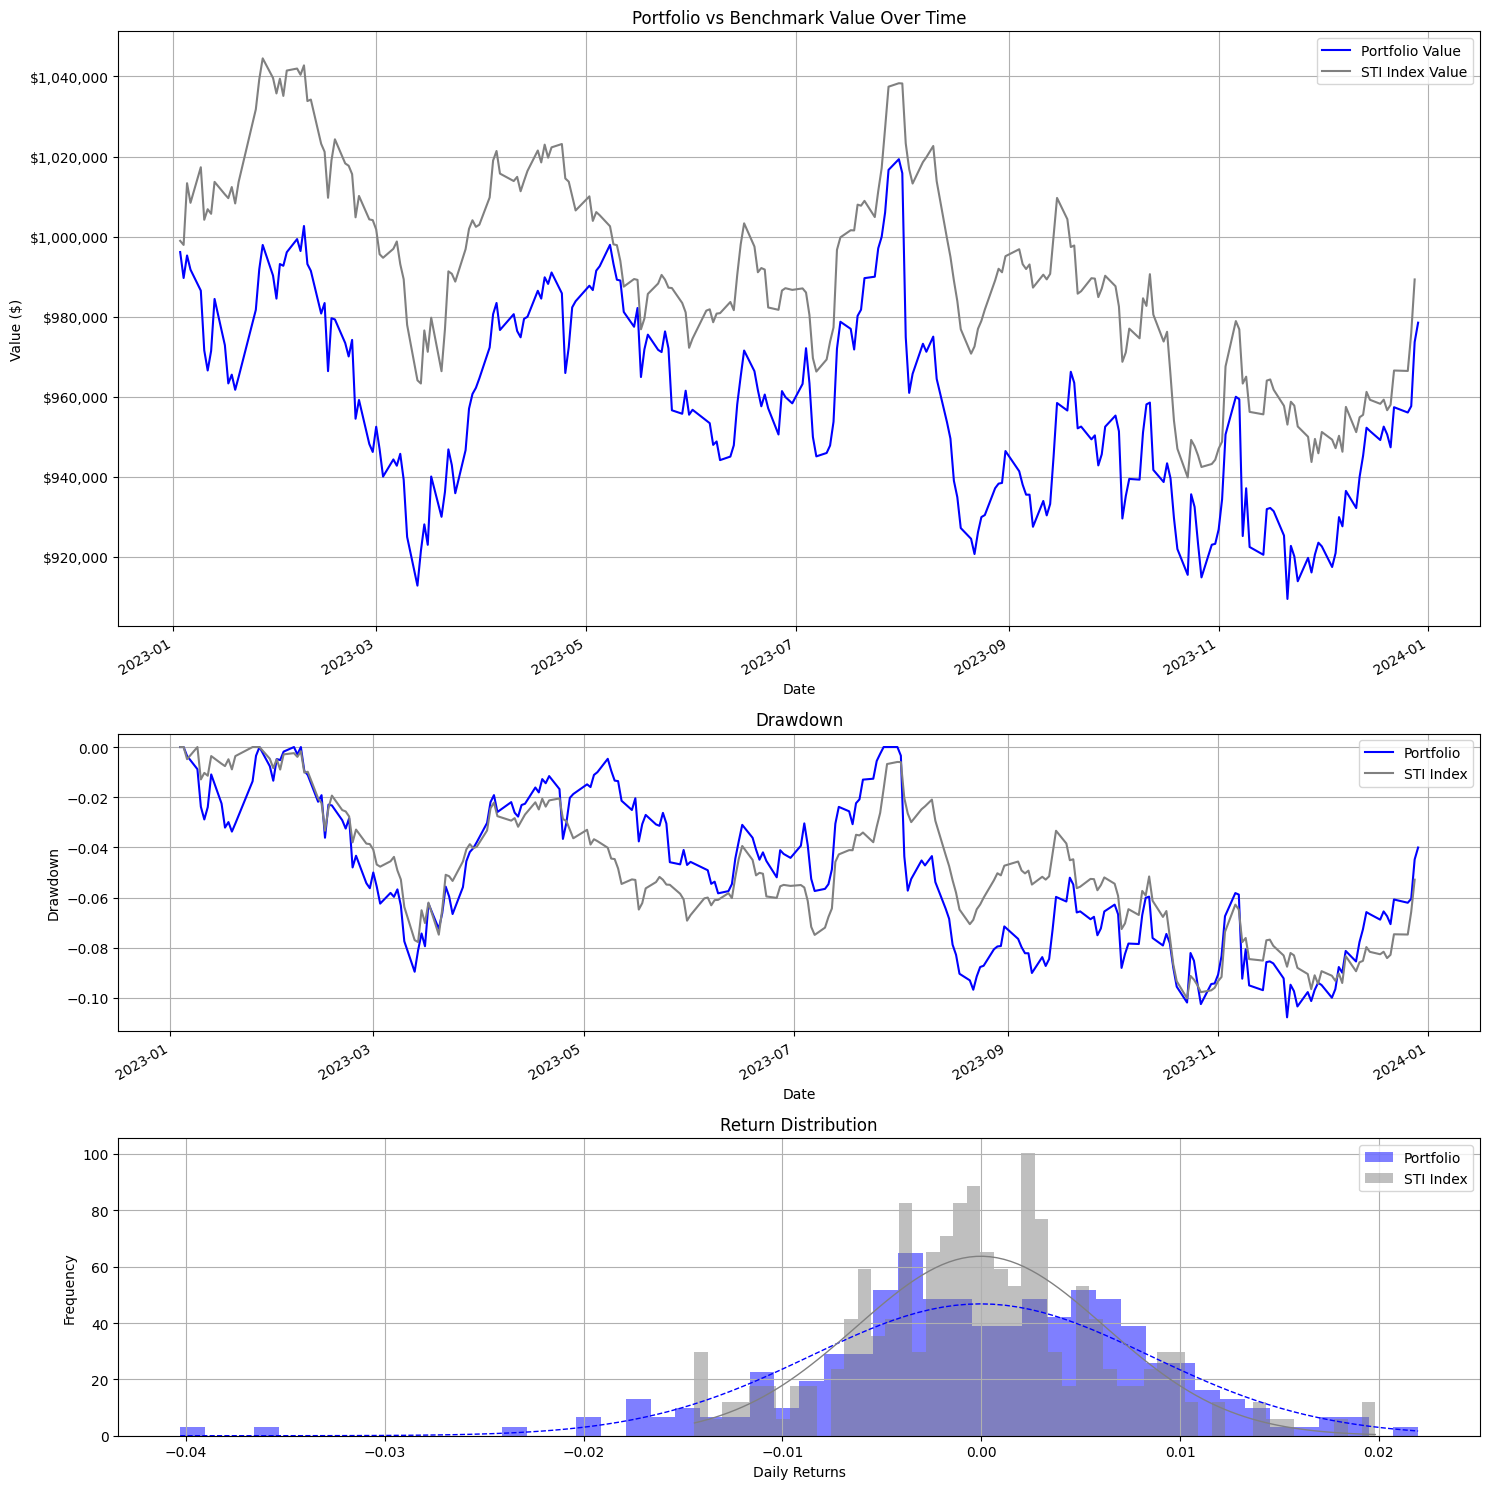

In [31]:
results_3 = analyze_portfolio_performance(
    stock_train_data=stock_train_data,
    stock_test_data=stock_test_data,
    weights=weights_3
)

# 8 Performance Discussion

Discuss the performance of the portfolios you backtested and select a suitable benchmark ETF (STI ETF or STI index) for benchmark comparisons. (you can/should calculate various performance metrics for comparison purposes).